# QuaSaR: Identifying EEW Rings - Mapping Station Faults

## GOAL AND OBJECTIVES
Quake Safety Rings (synonimus with [QuSaR](https://en.wikipedia.org/wiki/Quasar)) are essentially autonomous [Rings](https://brilliant.org/wiki/ring-theory/) of sensors sharing discretized time-series of _waveform_ information to identify threats and forewarn to give man and machine a lead time to respond to harmful earthquakes.

The overall __gaol__ is to examine how the GeoNet seismic network can be augmented with a low-cost network to offer low-latency EEWs by making use of cutting-edge earthquake picking algorithms and machine learning techniques. The expected outcome is for the findings to serve as evidence for supporting a strategic deployment of a ring or rings of micro-array networks. 

The intent is to also make use of the analysis and tools is to serve as inputs for earthquake hazard risk assessment. Thereby, a community interested in operationalizing their own micro-array ring can make us of the analysis and tools to determining whether or not and how they may need to invest in building a micro-array ring.

### Objectives
1. _Understand the [topology](https://brilliant.org/wiki/topology/) (structure of connection of the units and their capabilities)_; also an axiomatic way to make sense of when two points in a set are "near" each other
   1. Retrieve data on all the operational NZ seismic stations to __map the inventory__ by types and location [git-issue #2](https://github.com/waidyanatha/quasar/issues/2).
   1. Build a __statoion fault topology space__ comprising all the operational stations within a bound of the fault line paths; such that we create a metric space _(X,d)_ comprising _X = { x,y | for all coordinate pairs of stations x and faults y}_ and a [haversine](https://math.stackexchange.com/questions/993236/calculating-a-perpendicular-distance-to-a-line-when-using-coordinates-latitude) distance function _d = x - y_; relative to the fault lines, stations, and earthquake detection role and capacity 
   1. Cluster the metric space into partially ordered __coarser topology__ of metric subspaces; essentially to make a nearest neigbour map of station fault clusters such that stations are within ___d < &epsilon;___ distance to ensure optimal EEW application performance; 
1. _Apply earthquake __picking algorithms__ on the GeoNet wave form data_
   1. Test the __standard GeoNet algorithms__ (e.g. LTS/STS, Pd, Wavefields)
   1. Test with new __machine learning and wavefield algorithms__ (e.g. , 8bit Picking, PLUM)
   1. Test above picking algorithms with __simulated earthquakes__ and for __selected high risk faults__ to observe the response of the picking algorithms
   
1. _Determine ways for improving the station rings for an incremental effectiveness of EEW_
   1. Propose to __fit additional stations__ to improve the 30Km nearest neighbour cluster; then show how that improves the picking
   1. Apply the geodedic methodology to __interpolate seismic data__ for the proposed station locations 
   1. Try the earthquake __picking algorithms__ on the hypothetical network to measure effectiveness

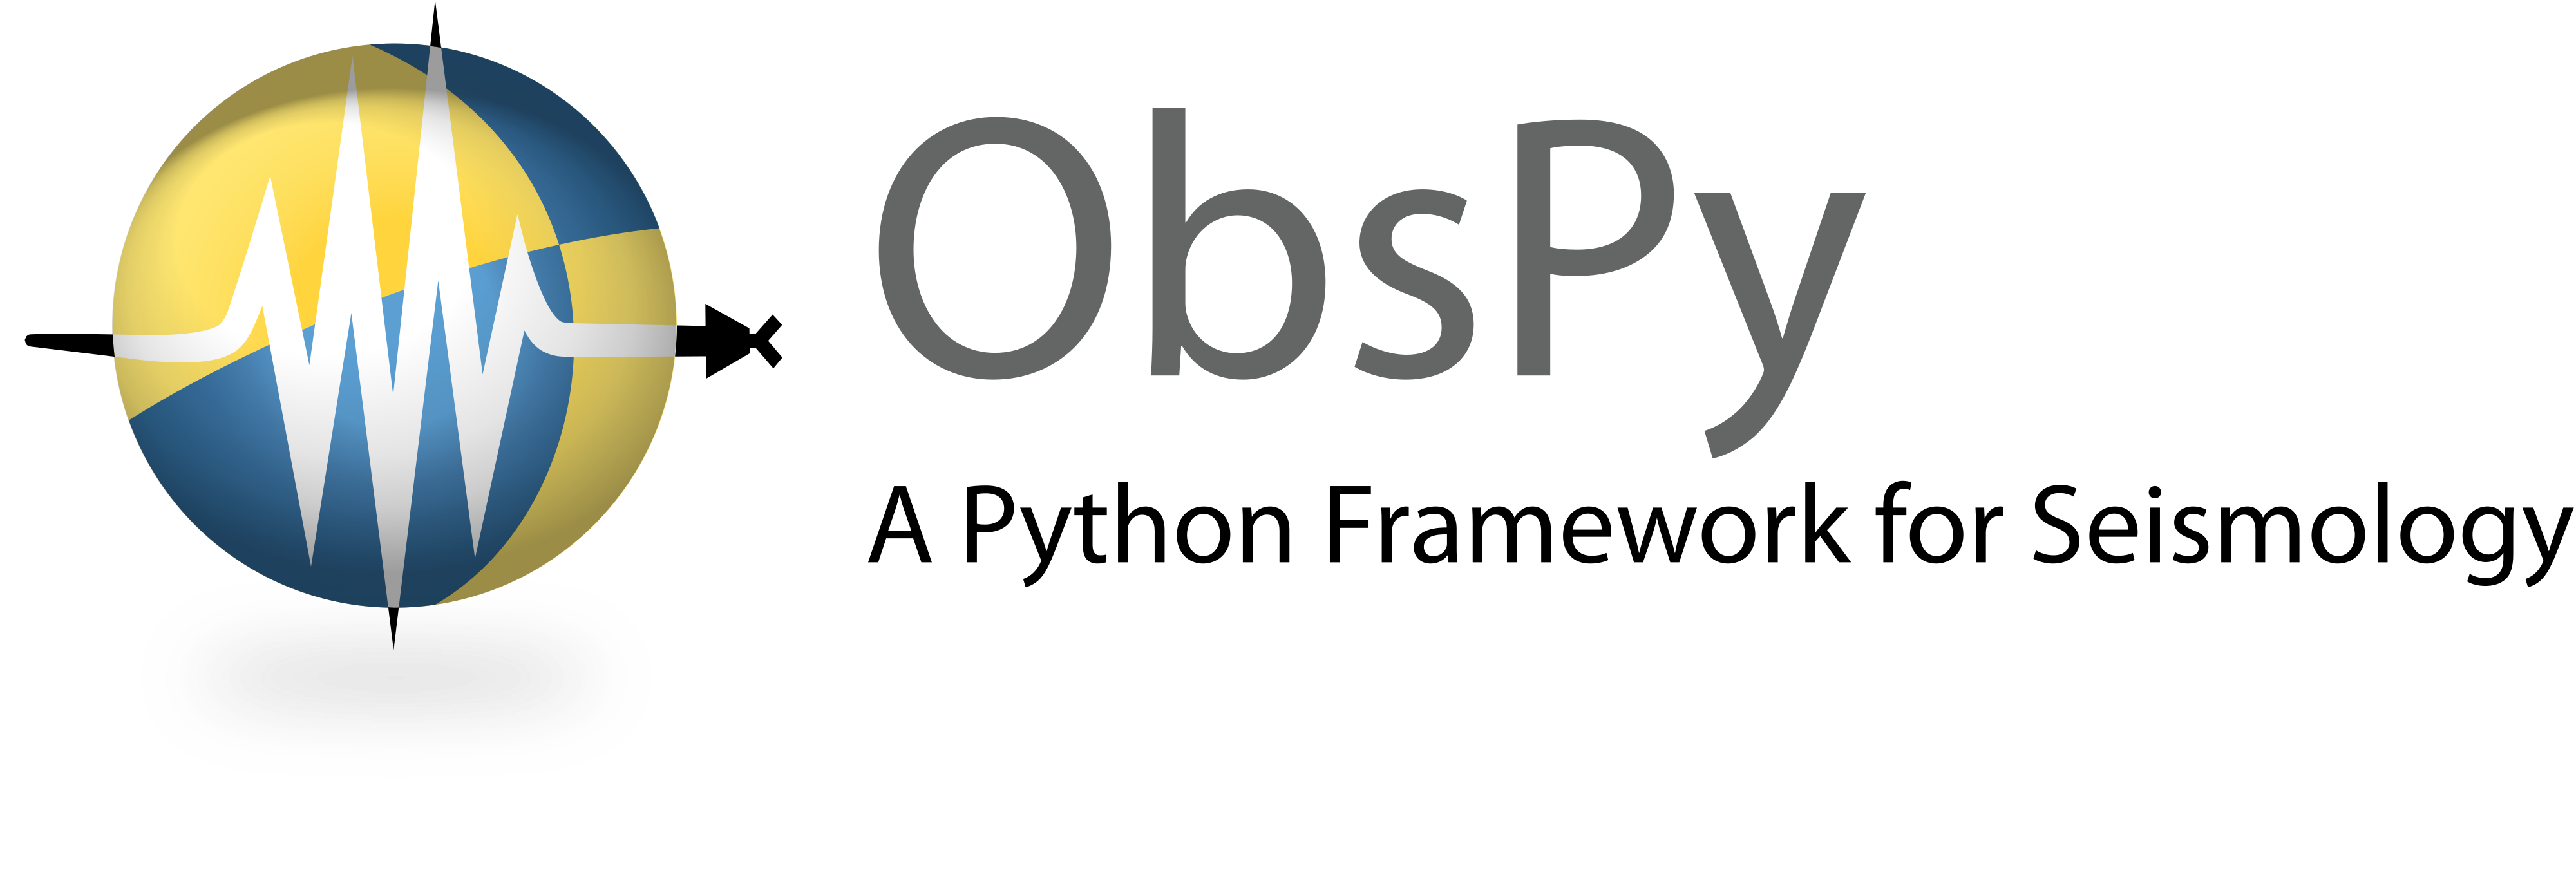

In [1]:
from IPython.display import Image
Image(filename='../images/obspy.png',width=300, height=150)

## OBJECTIVE 1.A - SENSORS AND FAULT LINES MAP

A plot of all activate sensors color coded by sensor type and fault lines color coded by type

### DEFINE data services and software modules

We make use of the International Federation Data of Seismic Networks (FDSN), the global standard and a [data service](http://www.fdsn.org/services/) for sharing seismic sensor wave form data. The Obspy librarires support FDSN. The list of resources and services that are used for retrieving station inventory and waveform data. 
1. ObsPy
   1. FSDN as Client data sources; both (i) the FDSN client service and the (ii) FDSN complient GoeNet API webservice
1. FDSN station service
   1. retrieve station metadata information in a FDSN StationXML format or text format for all the channels in CECS station with no time limitations: https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel&format=text


In [1]:
import glob
from obspy import read_inventory
from obspy.clients.fdsn import Client
from obspy.core import read, UTCDateTime
#from datetime import date

# Establish start and end time for retrieving waveform data
t_start = UTCDateTime.now()-518400 #6 days ago = 60s x 60m x 24h x 6d
t_end = UTCDateTime.now()+86400 #1 day in the future = 60s x 60m x 24h
print('Station startime: ', t_start, '\n & ending time: ', t_end)

try:
    #use either or GeoNet station service webservice URL or Obspy FDSN Client protocol to retrieve station data
    st_ws = 'https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&level=station&endafter=2020-12-31&format=xml'
    #st_ws = 'https://service.geonet.org.nz/fdsnws/station/1/query?network=NZ&station=CECS&level=channel'
    # Set FDSN client URL to GEONET short code
    client  = Client('GEONET')
    print("Client is",client)
except Exception as err:
    print("Error message:", err)


Station startime:  2021-01-04T03:40:49.098728Z 
 & ending time:  2021-01-11T03:40:49.098935Z
Client is FDSN Webservice Client (base url: http://service.geonet.org.nz)
Available Services: 'dataselect' (v1.1), 'event' (v1.1), 'station' (v1.1), 'available_event_catalogs', 'available_event_contributors'

Use e.g. client.help('dataselect') for the
parameter description of the individual services
or client.help() for parameter description of
all webservices.


### Sensor code and type definitions
<a id='sensor_code_desc'></a>

An initiatl step for object 1.A is determining the the types of operational seismic sensors and their locations. GoeNet hosts wave forms for a multitude of [sensor types](https://api.geonet.org.nz/network/sensor/type) (e.g. tidle guages, pressure gauges, seismometers, GNSS antennas, barometers, Microphones, Hydrophones and so on). The focus is on motion sensors of type: _(i) accelerometer, (ii) broadband velocity, (iii) short period velocity, and (iv) GNSS_. 

The sensors location code is unique to each sensor type. Therefore, one may chose to use the location code prefix or sensor type enumerator to select the desired sensors; i.e. seimograph and accelerometer stations. The motion sensors are used in both earthquake and volcanic seismic activity monitoring and early warning.

Channel codes are defined in the GeoNet's [stream naming conventions](https://www.geonet.org.nz/data/supplementary/channels)

| Sensor types that are relevant to earthquake detection | Location codes reserved for the seismic sensors | Channel codes first letter sensor type sampling rate and sensor bandwidth | Channel codes second letter sensor type relevant to seismometers |
|------------------------- |------------------------- |------------------------- |------------------------- |
|1 - Accelerometer |1? - weak motion sensors |U - Ultra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz |H - Weak motion sensor, e.g. measuring velocity |
|3 - Broadband Seismometer |2? - strong motion sensors |V - Very Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz |N - Strong motion sensor, e.g. measuring acceleration |
|4 - GNSS Antenna | |L - Broad band sampled at 1Hz, or SOH sampled at 1Hz |L - Low gain sensor, usually velocity |
|8 - Short Period Borehole Seismometer | |B - Broad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz |M - Mass position, used for monitoring broadband sensors |
|9 - Short Period Seismometer | |S - Short-period sampled at between 10 and 80 Hz, usually 50 Hz | |
|10 - Strong Motion Sensor | |H - High Broad band sampled at or above 80Hz, generally 100 or 200 Hz | |
| | |E - Extremely Short-period sampled at or above 80Hz, generally 100 Hz | |


### Plot senors by type

/home/nuwan/anaconda3/envs/obspy/lib/python3.7/site-packages/obspy/io/stationxml/core.py:98: UserWarning: The StationXML file has version 1, ObsPy can read versions (1.0, 1.1). Proceed with caution.
  version, ", ".join(READABLE_VERSIONS)))


Number of active stations: 453
Invalid stations: [['CTZ', -43.73549, -176.61719], ['GLKZ', -29.26068, -177.918038], ['RIZ', -29.2449, -177.9289]]
Number of valid active stations: 450


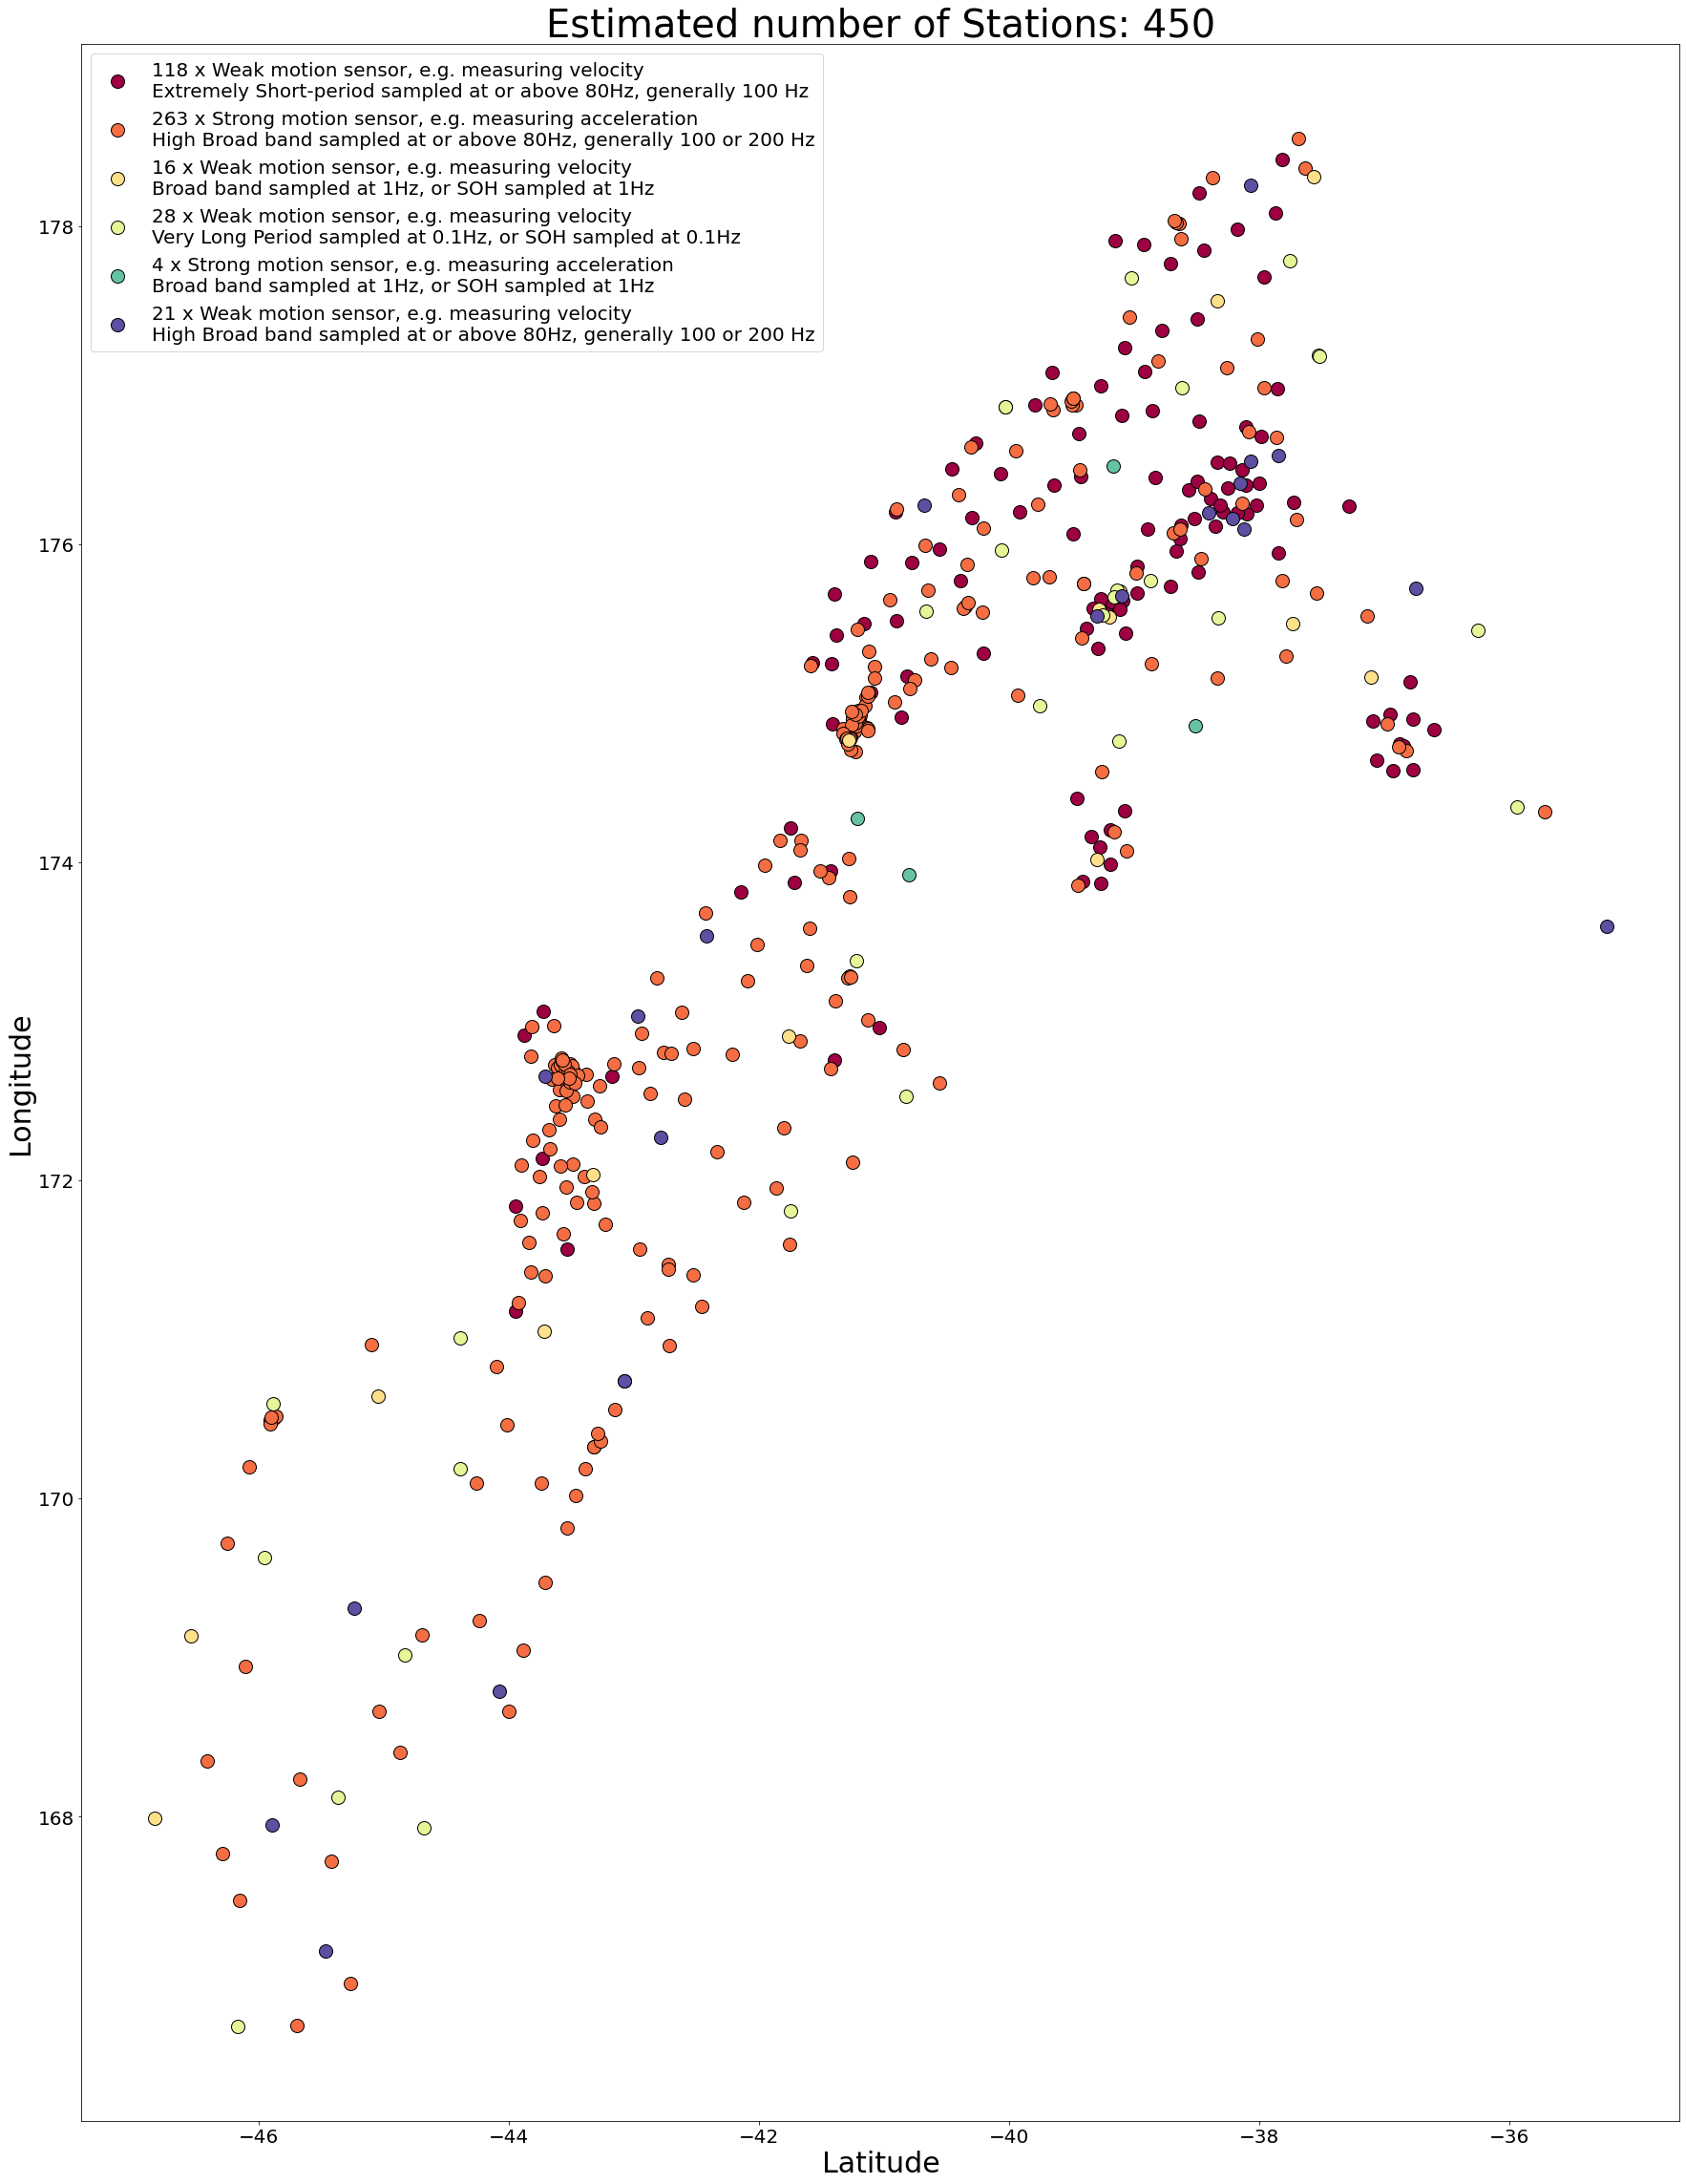

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(30, 40))
#fig, ax = plt.subplots(1,1,figsize=(30,40))

''' All weak & strong motion, low gain, and mass possion sensor types '''
channels = "UH*,VH*,LH*,BH*,SH*,HH*,EH*,UN*,VN*,LN*,BN*,SN*,HN*,EN*"
st_type = {"UH" : "Weak motion sensor, e.g. measuring velocity\nUltra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz",
           "VH" : "Weak motion sensor, e.g. measuring velocity\nVery Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz",
           "LH" : "Weak motion sensor, e.g. measuring velocity\nBroad band sampled at 1Hz, or SOH sampled at 1Hz",
           "BH" : "Weak motion sensor, e.g. measuring velocity\nBroad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz",
           "SH" : "Weak motion sensor, e.g. measuring velocity\nShort-period sampled at between 10 and 80 Hz, usually 50 Hz", 
           "HH" : "Weak motion sensor, e.g. measuring velocity\nHigh Broad band sampled at or above 80Hz, generally 100 or 200 Hz",
           "EH" : "Weak motion sensor, e.g. measuring velocity\nExtremely Short-period sampled at or above 80Hz, generally 100 Hz",
           "UN" : "Strong motion sensor, e.g. measuring acceleration\nUltra Long Period sampled at 0.01Hz, or SOH sampled at 0.01Hz",
           "VN" : "Strong motion sensor, e.g. measuring acceleration\nVery Long Period sampled at 0.1Hz, or SOH sampled at 0.1Hz",
           "LN" : "Strong motion sensor, e.g. measuring acceleration\nBroad band sampled at 1Hz, or SOH sampled at 1Hz",
           "BN" : "Strong motion sensor, e.g. measuring acceleration\nBroad band sampled at between 10 and 80 Hz, usually 10 or 50 Hz",
           "SN" : "Strong motion sensor, e.g. measuring acceleration\nShort-period sampled at between 10 and 80 Hz, usually 50 Hz",
           "HN" : "Strong motion sensor, e.g. measuring acceleration\nHigh Broad band sampled at or above 80Hz, generally 100 or 200 Hz",
           "EN" : "Strong motion sensor, e.g. measuring acceleration\nExtremely Short-period sampled at or above 80Hz, generally 100 Hz"}

try:
    st_inv = client.get_stations(network='NZ', location="1?,2?", station='*', 
                             channel=channels, level='channel', starttime=t_start, endtime = t_end)

    ''' Print the station inventory '''
    print('Number of active stations:', len(st_inv[0].stations))
    st_type_dict = {"st_type":[]}
    st_loc_list = []
    st_inv_err_dict = []

    for each_st in range(len(st_inv[0].stations)):
        ''' use lat/lon paris only in and around NZ'''
        if(st_inv[0].stations[each_st].latitude < 0 and st_inv[0].stations[each_st].longitude > 0):
            each_st_type_dict = st_inv[0].stations[each_st].get_contents()
            ''' get the second character representing the station type '''
            st_type_dict["st_type"].append(each_st_type_dict["channels"][0][-3:-1])
            ''' list of corresponding station locations (lat / lon) '''
            st_loc_list.append([st_inv[0][each_st].latitude, st_inv[0][each_st].longitude])
        else:
            st_inv_err_dict.append([st_inv[0].stations[each_st].code,st_inv[0][each_st].latitude, st_inv[0][each_st].longitude])

    print('Invalid stations:',st_inv_err_dict)
    print('Number of valid active stations:', len(st_loc_list))

    core_samples_mask = np.zeros_like(st_type_dict["st_type"], dtype=bool)
    core_samples_mask[0:sum([len(x) for x in st_type_dict["st_type"]])] = True

    unique_st_types = set(st_type_dict["st_type"])
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_st_types))]

    ''' convert list to array for color coding the locations by station types '''
    legend_elements = []
    st_loc_arr = np.array(st_loc_list)
    for k, col in zip(unique_st_types, colors):
        class_member_mask = (np.array(st_type_dict["st_type"]) == k)
        xy = st_loc_arr[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14, label=str(len(xy))+' x '+str(st_type[k]))
    
    plt.title('Estimated number of Stations: %d' % len(st_loc_arr), fontsize=40)
    plt.xlabel('Latitude', fontsize=30)
    plt.ylabel('Longitude', fontsize=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.legend(loc='upper left', fontsize=20)
    plt.show()

except Exception as err:
    print("Error message:", err)


### Fault line map

We have completed objective 1.A. However, we will also include a mapping of the fault lines to give a perception of the station distribution relative to that of the map of fault lines. 

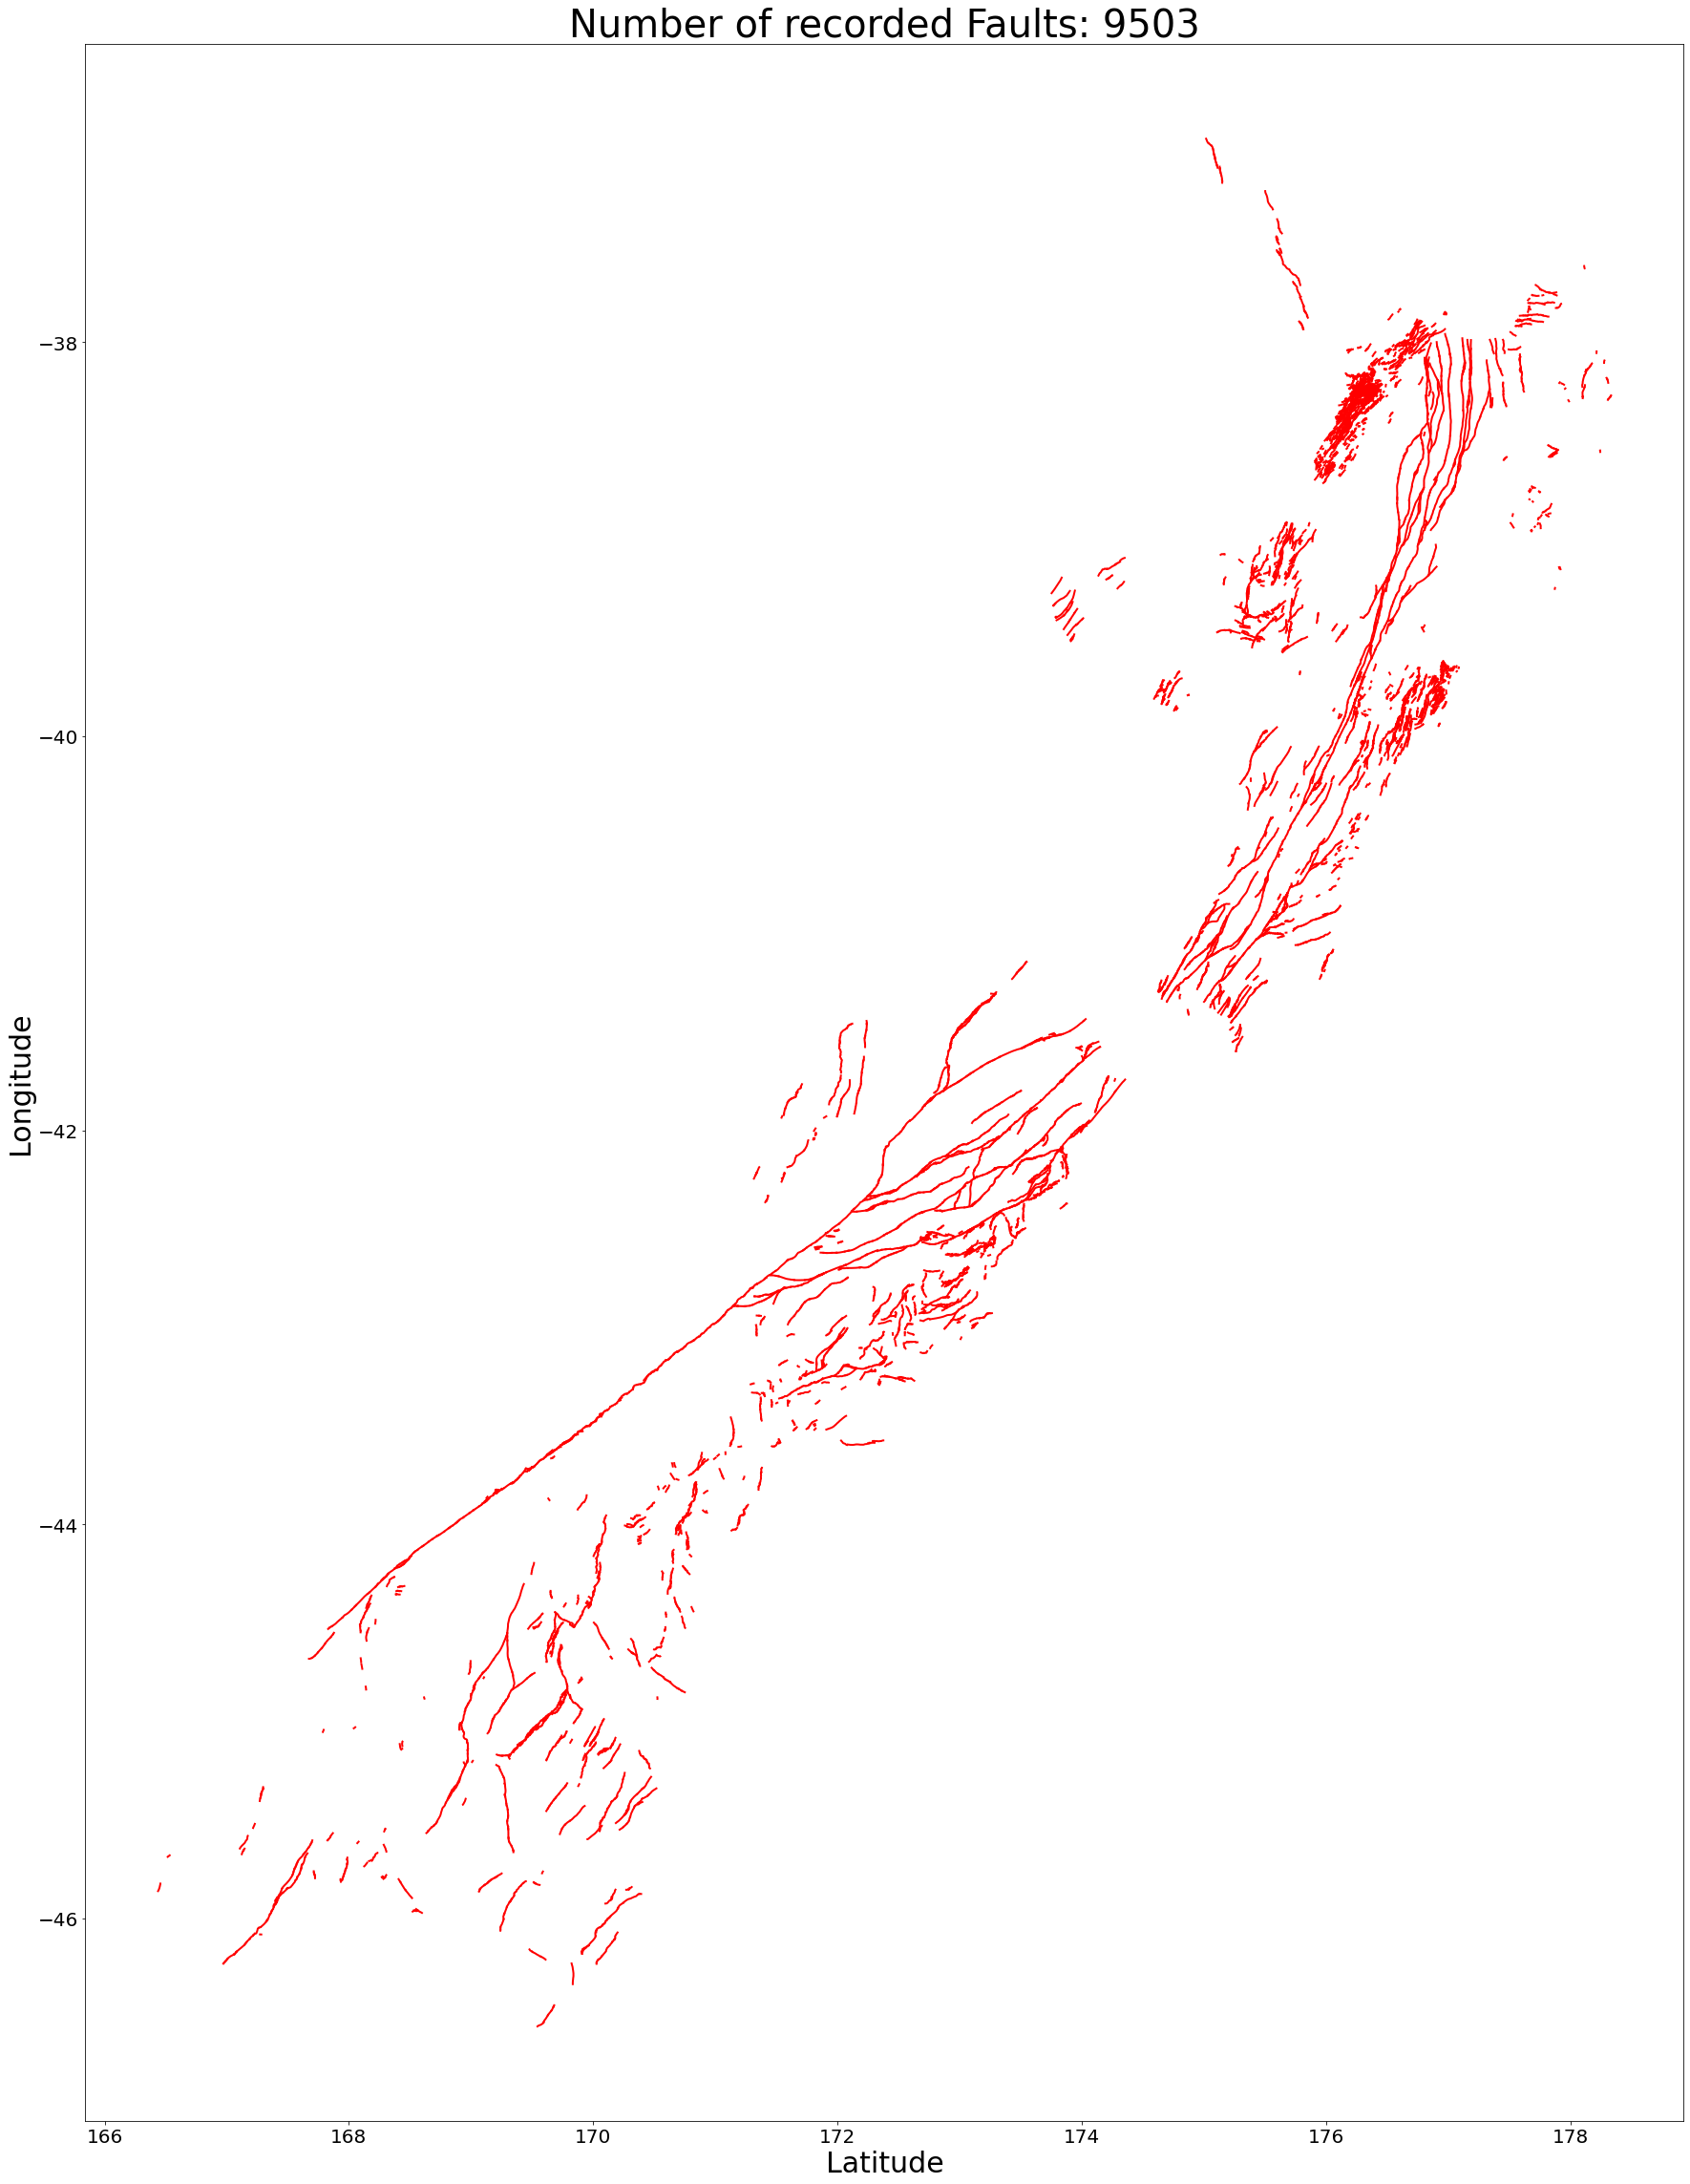

In [5]:
import matplotlib.pyplot as plt 
import json
from dictor import dictor

plt.figure(figsize=(30, 40))

'''Extract nested values from a JSON tree.'''

try:
    with open('/home/nuwan/workspace/quasar/data/NZAFD/JSON/NZAFD_Oct_2020_WGS84.json') as json_file: 
        data = json.load(json_file)

    for each_feature in range(len(data['features'])):
        points = {"x":[], "y":[]}
        path = dictor(data,'features.{}.geometry.paths.0'.format(each_feature))
        for each_coordinate in range(len(path)):
            points["x"].append(path[each_coordinate][0])
            points["y"].append(path[each_coordinate][1])
        plt.plot(points["x"],points["y"], color = 'red', linewidth=2, label="Faults")

    plt.title('Number of recorded Faults: %d' % len(data['features']), fontsize = 40)
    plt.xlabel('Latitude', fontsize=30)
    plt.ylabel('Longitude', fontsize=30)
    plt.xticks(size=20)
    plt.yticks(size=20)
#    plt.legend(loc='upper left', fontsize=20)
    plt.show()
except Exception as err:
    print("Error message:", err)

## RESOURCES
1. [Global data services and standards](http://www.fdsn.org/services/) offered by the International Federation Data of Seismic Networks (FDSN). 
1. GEONET resources:
   1. [Stream Naming Conventions](https://www.geonet.org.nz/data/supplementary/channels) are based on historical usage together with recommendations from the [SEED manual](https://www.fdsn.org/seed_manual/SEEDManual_V2.4.pdf)
   1. [Python tutorials](https://www.geonet.org.nz/data/tools/Tutorials) for using GeoNet resources
1. [Seismo-Live](https://krischer.github.io/seismo_live_build/html/Workshops/2017_Baku_STCU_IRIS_ObsPy_course/07_Basic_Processing_Exercise_solution_wrapper.html) examples of get station waveform, inventory, event, arrival time, response, and plotting using obspy
1. Choosing [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) over KMeans: 
   1. Fundermentally KMeans requires us to first select the number of clusters we wish to find and DBSCAN doesn't.
   1. [clustering to reduce spatial data sizes](https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/) KMeans is not an ideal algorithm for latitude-longitude spatial data because it minimizes variance, not geodetic distance. 
   1. [Explanation of DBSCAN clustering](https://towardsdatascience.com/explaining-dbscan-clustering-18eaf5c83b31) also identifies a drawback of KMeans clustering as it is vulnerable to outliers and outliers have a significant impact on the way the centroids moves.
1. [Example of scikit-learn DBSCAN](https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html)
1. [obspy.geodetics](https://docs.obspy.org/packages/obspy.geodetics.html) - various geodetic utilities for ObsPy - try an alternative clustering method with obspy geodetics
1. Mapping tutorials
   1. Visualization: [Mapping Global Earthquake Activity](http://introtopython.org/visualization_earthquakes.html)
   1. Plotting data on a map [(Example Gallery)](https://matplotlib.org/basemap/users/examples.html)